# Stock Price Forecasting In Time Series Data Analysis

In [ ]:
# Install yfinance library

!pip install yfinance

In [ ]:
# Install fredapi

! pip install fredapi

In [ ]:
# Import important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import datetime
import statsmodels.api as sm
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory Data Analysis

In [ ]:
# We chose three stocks Boeing, Amazon and IBM

stocks = ['BA','IBM','AMZN','^GSPC']
start = datetime.datetime(2010,1,1) 
end = datetime.datetime(2022,3,27) 
stock_prices = yf.download(stocks, start=start ,end = end, interval='1d')['Close']

[*********************100%***********************]  4 of 4 completed


In [ ]:
# Rename the market index column name

stock_prices = stock_prices.rename({'^GSPC':'GSPC'}, axis='columns')
stock_prices.head()

,AMZN,BA,IBM,GSPC
Date,,,,
2010-01-04,133.899994,56.180000,126.625237,1132.989990
2010-01-05,134.690002,58.020000,125.095604,1136.520020
2010-01-06,132.250000,59.779999,124.282982,1137.140015
2010-01-07,130.000000,62.200001,123.852776,1141.689941
2010-01-08,133.520004,61.599998,125.095604,1144.979980


In [ ]:
# We have a total of 3079 entries starting from January1, 2010 to March 27, 2022

stock_prices.shape

(3079, 4)

In [ ]:
stock_prices.describe()

,AMZN,BA,IBM,GSPC
count,3079.000000,3079.000000,3079.000000,3079.000000
mean,1104.415382,172.532988,149.340148,2301.836195
std,1067.770497,99.295866,24.421704,931.442200
min,108.610001,56.180000,90.602295,1022.580017
25%,259.145004,77.089996,129.861374,1494.815002
50%,625.900024,139.000000,145.009567,2095.149902
75%,1776.475037,226.900002,169.708412,2828.964966
max,3731.409912,440.619995,206.309753,4796.560059


The *describe()* fuction shows us that Amazon has a mean 1101, min of 108 and max price of 3731 with high standard devation 1065. Boeing has mean of 172, min 77 and max price of 440 with a standard devation 99. IBM has mean of 149, min 90 and max price of 209 with a standard devation of 24. Amazon looks more volitile than others.

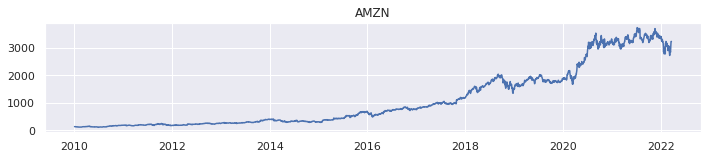

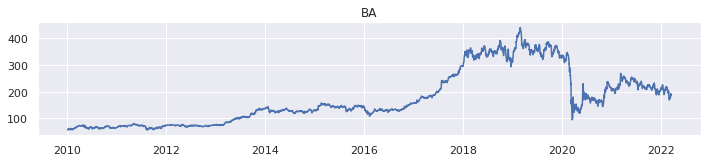

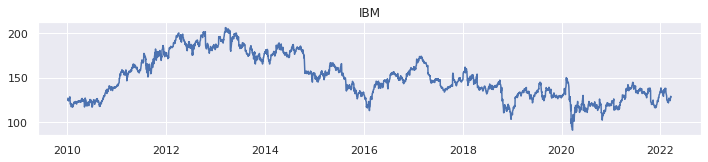

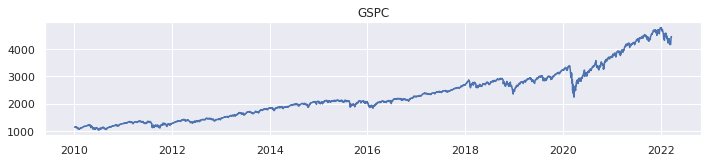

In [ ]:
# Plot the closing prices for those three stocks

for i, stock in enumerate(stock_prices.columns, start=1):
    sns.set
    plt.figure(figsize=(10, 10))
    plt.subplot(5, 1, i)
    plt.plot(stock_prices[stock])
    plt.title(f"{stock}")
    plt.tight_layout()
    plt.show() 

The above graphs show how stock prices are fluctuating over time. Amazon had a steadily increasing trend at first and strted fluctuating frequently since 2019. Boeing a little fluctuation at the beginning and got its peak end of 2018 then started to down. IBM was fluctuating all the time and got its lowest in 2020. 

### stocks' returns:
It is a percentage change from the previous day. A postive change brings postive return and a negative change brings a negative return from the stocks.

In [ ]:
stock_returns = stock_prices.pct_change()
stock_returns.dropna(inplace=True)
stock_returns.head()

,AMZN,BA,IBM,GSPC
Date,,,,
2010-01-05,0.005900,0.032752,-0.012080,0.003116
2010-01-06,-0.018116,0.030334,-0.006496,0.000546
2010-01-07,-0.017013,0.040482,-0.003462,0.004001
2010-01-08,0.027077,-0.009646,0.010035,0.002882
2010-01-11,-0.024041,-0.011851,-0.010470,0.001747


In [ ]:
# To get risk free rate, needed federal issued bills


from fredapi import Fred
fred = Fred(api_key='a9de54600eb256ba2175aa2fd019e1bd')

In [ ]:
fred.search('risk free')

In [ ]:
# Find 3 months risk free rate and change into daily rate by dividing into 90 days.

risk_free = fred.get_series('DGS3MO')
risk_free = risk_free['2010-01-01':'2022-03-22']
risk_free = risk_free /90
risk_free = risk_free.dropna().iloc[:-1]

In [ ]:
risk_free.shape

(3057,)

(array([733042., 733773., 734503., 735234., 735964., 736695., 737425.,
        738156.]), <a list of 8 Text major ticklabel objects>)

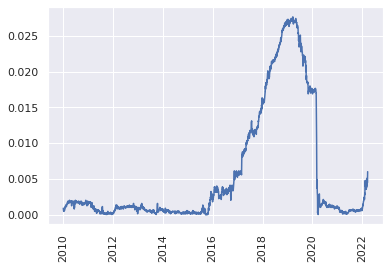

In [ ]:
plt.plot(risk_free)
plt.xticks(rotation=90)

The risk free rate is as low as below 0.005 most of the time except the duration 2017 to 2020. In this time period it was higher than 0.25.

###  Excess return: 
 
It is a measure of how much a fund has under or outperformed the benchmark against which it is compared.It is calculated by subtracting a risk_free_rate from each stock's return. 

In [ ]:

stocks = ["AMZN","BA", "IBM", "GSPC"]
for i in stocks:
    stock_returns[f"excess_return_{i}"] = stock_returns[i] - risk_free
stock_returns.dropna(inplace=True)


In [ ]:
stock_returns.shape


(3051, 8)

# Capital Asset Pricing Model (CAPM)


CAPM is a univariate approach that describes the relationship between systematic risk and expected return for assets.


​


## Amazon Stock CAPM

In [ ]:
y_amzn = stock_returns['excess_return_AMZN']
X = stock_returns['excess_return_GSPC']
X = sm.add_constant(X, prepend=False)
CAPM_AMZN = sm.OLS(y_amzn, X)
CAPM_results_AMZN = CAPM_AMZN.fit()

In [ ]:
CAPM_results_AMZN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_AMZN   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     2177.
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:59:10   Log-Likelihood:                 8193.7
No. Observations:                3051   AIC:                        -1.638e+04
Df Residuals:                    3049   BIC:                        -1.637e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.0140      0.022     46.656      0.000       0.971       1.057
const                  0.0008      0.000      2.462      0.014       0.000       0.001
==============================================================================
Omnibus:                      933.455   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28270.391
Skew:                           0.824   Prob(JB):                         0.00
Kurtosis:                      17.821   Cond. No.                         72.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the CAPM theory, the beta of a potential investment is a measure of how much risk the investment will add to a portfolio. If a stock is riskier than the market, it will have a beta greater than one. If a stock has a beta of less than one, the formula assumes it will reduce the risk of a portfolio. In the above CAPM summary Amazon has beta value greater than 1 that makes it riker than the market index. It has stastsically signficant beta value since the P-value is 0.000. Adjusted R square shows 41%  Amazon stock return is explained by market index return.

## Boeing Stock CAPM

In [ ]:
y_ba = stock_returns['excess_return_BA']
X = stock_returns['excess_return_GSPC']
X = sm.add_constant(X, prepend=False)
CAPM_BA = sm.OLS(y_ba, X)
CAPM_results_BA = CAPM_BA.fit()

In [ ]:
CAPM_results_BA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       excess_return_BA   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     2836.
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:59:27   Log-Likelihood:                 8048.1
No. Observations:                3051   AIC:                        -1.609e+04
Df Residuals:                    3049   BIC:                        -1.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.2138      0.023     53.250      0.000       1.169       1.259
const                  0.0012      0.000      3.683      0.000       0.001       0.002
==============================================================================
Omnibus:                     1240.107   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56111.052
Skew:                           1.191   Prob(JB):                         0.00
Kurtosis:                      23.874   Cond. No.                         72.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the above CAPM summary Boeing has beta value greater than 1 that makes it riker than the market index. It has stastsically signficant beta value since the P-value is 0.000. Adjusted R square shows 48%  Boeing stock return is explained by market index return.

## IBM Stock CAPM

In [ ]:
y_ibm = stock_returns['excess_return_IBM']
X = stock_returns['excess_return_GSPC']
X = sm.add_constant(X, prepend=False)
CAPM_IBM = sm.OLS(y_ibm, X)
CAPM_results_IBM = CAPM_IBM.fit()

In [ ]:
CAPM_results_IBM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      excess_return_IBM   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     4344.
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:59:35   Log-Likelihood:                 9541.1
No. Observations:                3051   AIC:                        -1.908e+04
Df Residuals:                    3049   BIC:                        -1.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     0.9210      0.014     65.908      0.000       0.894       0.948
const                 -0.0008      0.000     -3.897      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1088.195   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36446.459
Skew:                          -1.039   Prob(JB):                         0.00
Kurtosis:                      19.804   Cond. No.                         72.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the OLS model summary above, we can see that the P value is statistically significant so we reject the null hypotesis.Since beta is greater than 1, the investment on IBM stock is riskier than the market index. The dependant variable IBM exess return is explianed by the independant variable excess market index by 59%.



In all the three stocks Boeing is risker and IBM is the least risk one.

## Measure The Risk/Return Ratio for the Investment

### 1.  Sharpe Ratio

Sharpe=(ri−rf)/σi 

where  ri  and  σi  denote return and standard deviation of the stock, respectively.

rf  is risk free rate

It is one of the most referenced risk/return measures used in finance, describes how much excess return we receive for the extra volatility. The higher the Sharpe ratio is, the higher the return we gain per risk from the investment





In [ ]:
# To find sharpe ratios for those two stocks
AMZN_sharpe_ratio = (stock_returns['AMZN'].mean()- risk_free.mean()) /np.std(stock_returns['AMZN']) # risk free rate mean subtracted from amazon stock
                                                                                                        # return mean and divided by its standard deviation.

BA_sharpe_ratio= (stock_returns['BA'].mean()- risk_free.mean()) /np.std(stock_returns['BA']) # Boieng sock return mean minus risk free meandivided by Boeing's stock 
                                                                                                        # standard deviation
                                                                                                        
IBM_sharpe_ratio= (stock_returns['IBM'].mean()- risk_free.mean()) /np.std(stock_returns['IBM']) # IBM sock return mean minus risk free meandivided by IBM's stock 
                                                                                                        # standard deviation

In [ ]:
print('Amazon Sharpe Ratio: ', AMZN_sharpe_ratio)
print('Boeing Sharpe Ratio: ', BA_sharpe_ratio)
print('IBM Sharpe Ratio: ', IBM_sharpe_ratio)

Amazon Sharpe Ratio:  -0.2231319791648776
Boeing Sharpe Ratio:  -0.2235309407015894
IBM Sharpe Ratio:  -0.39106878134648765


From the above results, Amazon and Boeing have similar higher sharp ratio than IBM.

### 2. Treynor ratio

Treynor Ratio is a risk/return measure that allows investors to adjust a portfolio's returns for systematic risk.

Treynor ratio = (ri-rf)/Bi

Beta refers to systematic risk that measures the tendency of a portfolio's return to change in response to changes in return for the overall market.

In [ ]:
# To find betas for the two investments we use the result from CAPM summary, the coefficients
betas = [CAPM_results_AMZN.params[0],CAPM_results_BA.params[0], CAPM_results_IBM.params[0]]
df_betas = pd.DataFrame(betas,columns=['betas'])
df_betas

,betas
0,1.013963
1,1.213839
2,0.920983


In [ ]:
# To get Treynor Ratio

AMZN_treynor_ratio= (stock_returns['AMZN'].mean()- risk_free.mean())/df_betas.iloc[0]
BA_treynor_ratio= (stock_returns['BA'].mean()- risk_free.mean())/df_betas.iloc[1]
IBM_treynor_ratio= (stock_returns['IBM'].mean()- risk_free.mean())/df_betas.iloc[2]

In [ ]:
print('Amazon Stock Treynor Ratio: ', AMZN_treynor_ratio)
print('Boeing Stock Treynor Ratio: ', BA_treynor_ratio)
print('IBM Stock Treynor Ratio: ', IBM_treynor_ratio)

Amazon Stock Treynor Ratio:  betas   -0.004383
Name: 0, dtype: float64
Boeing Stock Treynor Ratio:  betas   -0.004144
Name: 1, dtype: float64
IBM Stock Treynor Ratio:  betas   -0.006025
Name: 2, dtype: float64


 Since higher treynor ratio means the investment is suitable to invest, Amazon and Boeing have the same higher ratio than IBM. They are better than IBM to invest. 

 In both ratio measures, Amazon and Boeing are better to invest than IBM.

# LSTM model for stock price forecasting 

In [ ]:
stock_prices.head()

,AMZN,BA,IBM,GSPC
Date,,,,
2010-01-04,133.899994,56.180000,126.625237,1132.989990
2010-01-05,134.690002,58.020000,125.095604,1136.520020
2010-01-06,132.250000,59.779999,124.282982,1137.140015
2010-01-07,130.000000,62.200001,123.852776,1141.689941
2010-01-08,133.520004,61.599998,125.095604,1144.979980


In [ ]:
# Take each stock's data to process for the model

stock_prices_amzn=stock_prices['AMZN'].copy()
stock_prices_ba=stock_prices['BA'].copy()
stock_prices_ibm=stock_prices['IBM'].copy()


### Scale The Data

In [ ]:
# Since prices of stocks are in different scale, scale the data using MinMax scaler

scaler = MinMaxScaler(feature_range=(0,1))  
stock_prices_amzn = scaler.fit_transform(np.array(stock_prices_amzn).reshape(-1,1))
stock_prices_ba = scaler.fit_transform(np.array(stock_prices_ba).reshape(-1,1))
stock_prices_ibm = scaler.fit_transform(np.array(stock_prices_ibm).reshape(-1,1))


### Set up the X features and y label

The following function helps us to get X values and y values. The function creates a list of X values with step_size length of days values and assigned the next value as y with slide 1. In our case, we use a step_size of 50.

In [ ]:
# Before we fit the model we are going to set X features and y label

def get_x_y(data, step_size):

  X = []  
  y = []
  for i in range(len(data) - step_size):
    row = [a for a in data[i:i + step_size]]
    X.append(row)
    label = data[i + step_size]
    y.append(label)
  return np.array(X), np.array(y)


# Amazon Stock Price Prediction

In [ ]:
step_size = 50
X,y = get_x_y(stock_prices_amzn, step_size)
X.shape, y.shape

# Split the data into train, validation and test
test_size = 0.15
X_train, y_train = X[:2000], y[:2000]
X_val, y_val = X[2000:2610], y[2000:2610]
X_test, y_test = X[2610:],   y[2610:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2000, 50, 1), (2000, 1), (610, 50, 1), (610, 1), (419, 50, 1), (419, 1))

In [ ]:
stock_prices_amzn.shape

(3079, 1)

##  Build the LSTM model For Amazon Stock


In [ ]:


n_features = 1  
n_steps = step_size

model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(n_steps, n_features)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
# fit the model
model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=100, verbose=1)

Epoch 1/100
63/63 [==============================] - 15s 138ms/step - loss: 9.0939e-04 - val_loss: 0.0018
Epoch 2/100
63/63 [==============================] - 7s 111ms/step - loss: 5.1286e-05 - val_loss: 8.8916e-04
Epoch 3/100
63/63 [==============================] - 7s 113ms/step - loss: 4.5384e-05 - val_loss: 0.0014
Epoch 4/100
63/63 [==============================] - 7s 113ms/step - loss: 4.7336e-05 - val_loss: 7.7719e-04
Epoch 5/100
63/63 [==============================] - 7s 113ms/step - loss: 4.3168e-05 - val_loss: 7.4025e-04
Epoch 6/100
63/63 [==============================] - 7s 113ms/step - loss: 3.9049e-05 - val_loss: 0.0015
Epoch 7/100
63/63 [==============================] - 7s 112ms/step - loss: 4.0215e-05 - val_loss: 0.0014
Epoch 8/100
63/63 [==============================] - 7s 107ms/step - loss: 4.0636e-05 - val_loss: 0.0011
Epoch 9/100
63/63 [==============================] - 7s 112ms/step - loss: 3.7776e-05 - val_loss: 0.0017
Epoch 10/100
63/63 [======================

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 100)           40800     
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            30200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


We run a simple LSTM model with one input layer two hiden layers and one out put layer. we use Adams for optimizer and loss function Mean Square Error, epoch 100.

### Prediction And Check Prformance Metrics

In [ ]:
# As we splited our data into three parts, the next will see how our model works on unseen test data.
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# Transform the scaled prices back to the original price form

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
train_predict

array([[ 91.47267 ],
       [ 91.46487 ],
       [ 91.499535],
       ...,
       [134.9043  ],
       [135.35788 ],
       [135.4044  ]], dtype=float32)

In [ ]:
test_predict = test_predict.flatten()
y_test = y_test.flatten()

test_results = pd.DataFrame(data={'Test Predictions': test_predict,'Actuals': y_test})
test_results.head()

,Test Predictions,Actuals
0,182.999451,184.020389
1,185.173950,184.606459
2,185.086594,188.209144
3,189.079544,186.523100
4,185.604782,187.383534


In [ ]:
#Put the results into the dataframe for visualization

train_predictions = train_predict.flatten()
y_train = y_train.flatten()

train_results = pd.DataFrame(data={'Train Predictions': train_predictions,'Actuals': y_train})
train_results.head()

,Train Predictions,Actuals
0,91.472672,91.328261
1,91.464867,91.373614
2,91.499535,91.296642
3,91.445663,91.300475
4,91.436279,91.261829


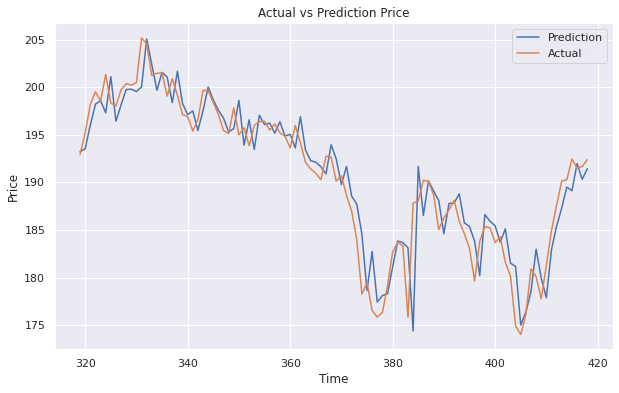

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Test Predictions'][-100:], label = 'Prediction')
plt.plot(test_results['Actuals'][-100:], label= 'Actual')
plt.title('Actual vs Prediction Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
### Calculate RMSE performance metrics for Training data

math.sqrt(mean_squared_error(y_train,train_predict))

0.42432751141618175

In [ ]:
### Calculate RMSE for prediaction

math.sqrt(mean_squared_error(y_test,test_predict))

2.114477727535601

The model performes well on prediction of Amazon stock price. When we see the dataframe for the actual and prediction price, the values are close and the graph also shows the same thing that both the actual and the prediction prices are matched. Moreover, the RMSE values are also small for both train and test data.

## Forecast the Stock Prices of Amazon for the next 30 days 

In [ ]:
# We split the data into train and test for simplicity of our function

train_data = stock_prices_amzn[:2610]
test_data = stock_prices_amzn[2610:]

In [ ]:
test_data.shape

(469, 1)

The fuction below helps our trained model to forcast the next 30 days using the previous 50 days. It sarted from the end date of our test data and iterate through the end of 30 future days and forecast the value ahead.

In [ ]:
# A function to help us to forcast the next 30 days

def forcast_30days(test_data, model, step_size, n_future):
  

  x_input = test_data[-step_size:].reshape(1,-1) # First get the last date of test data

  new_input=list(x_input)
  new_input=new_input[0].tolist()

  output=[]
 
  for i in range(n_future):
      
      if(len(new_input) > step_size):
          #print(new_input)
          x_input=np.array(new_input[1:])
          print("{} day input {}".format(i,x_input))
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, step_size, 1))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          print("{} day output {}".format(i,yhat))
          new_input.extend(yhat[0].tolist())
          new_input=new_input[1:]
          #print(new_input)
          output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, step_size,1))
          yhat = model.predict(x_input, verbose=0)
          #print(yhat[0])
          new_input.extend(yhat[0].tolist())
         # print(len(new_input))
          output.extend(yhat.tolist())
          i=i+1
  return output

In [ ]:
amzn_forcast = forcast_30days(test_data, model, 50, 30)

#The output shows that look back 50 days and forecast the next value for each 30 days

1 day input [0.86511816 0.84733912 0.83288342 0.80731483 0.75749425 0.76798883
 0.742826   0.73667882 0.74090208 0.76486423 0.79575468 0.80469808
 0.80149058 0.73652975 0.84028379 0.84191786 0.8611185  0.85988189
 0.84781389 0.81629132 0.82663414 0.83405102 0.84282877 0.82379378
 0.81247104 0.79919952 0.76955121 0.80560616 0.81902398 0.81777909
 0.80441376 0.80944025 0.78650768 0.77404498 0.72884237 0.72090099
 0.73892297 0.78053996 0.7734018  0.75313297 0.78357076 0.81524516
 0.83807279 0.86021864 0.86154912 0.88030532 0.87212929 0.87346253
 0.87966767 0.87859982]
1 day output [[0.8764379]]
2 day input [0.84733912 0.83288342 0.80731483 0.75749425 0.76798883 0.742826
 0.73667882 0.74090208 0.76486423 0.79575468 0.80469808 0.80149058
 0.73652975 0.84028379 0.84191786 0.8611185  0.85988189 0.84781389
 0.81629132 0.82663414 0.83405102 0.84282877 0.82379378 0.81247104
 0.79919952 0.76955121 0.80560616 0.81902398 0.81777909 0.80441376
 0.80944025 0.78650768 0.77404498 0.72884237 0.72090099 

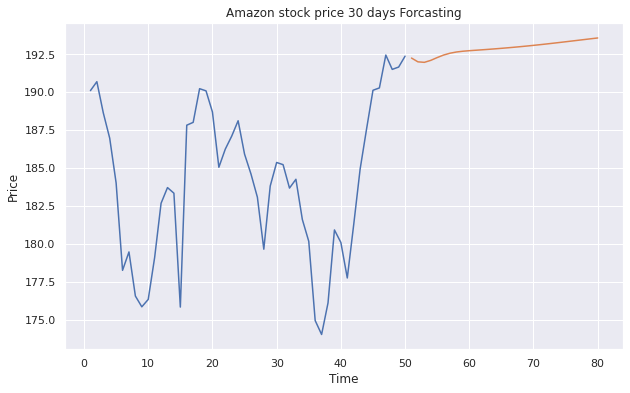

In [ ]:
# Plot the last 50 days plus 30 days future, total 80 days 

day_new = np.arange(1,51)
day_pred = np.arange(51,81)
plt.figure(figsize=(10,6))
plt.plot(day_new,scaler.inverse_transform(stock_prices_amzn[3029:]))
plt.plot(day_pred,scaler.inverse_transform(amzn_forcast))
plt.title('Amazon stock price 30 days Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

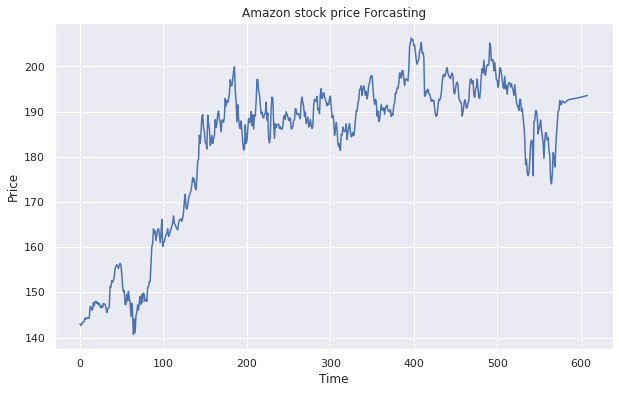

In [ ]:
# Plot all the data including the 30 days forcast values, for clear visualization we took only after 2500 days.

plt.figure(figsize=(10,6))
new_amzn=stock_prices_amzn.tolist()
new_amzn.extend(amzn_forcast)
plt.plot(scaler.inverse_transform(new_amzn[2500:]))
plt.title('Amazon stock price Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

The forcast by LSTM model for Amazon stock price shows that the price will increase for the next 30 days.

# Boeing Stock Price Prediction


Using the pervious function, we can get the X and y values for Boeing Stock Price, then split the data into train, validation and test data.

In [ ]:
step_size = 50
Xba,yba = get_x_y(stock_prices_ba, step_size) # The function we created before to get X and y values
Xba.shape, yba.shape

# Split the data into train, validation and test
test_size = 0.15
Xba_train, yba_train = Xba[:2000], yba[:2000]
Xba_val, yba_val = Xba[2000:2610], yba[2000:2610]
Xba_test, yba_test = Xba[2610:],   yba[2610:]

Xba_train.shape, yba_train.shape, Xba_val.shape, yba_val.shape, Xba_test.shape, yba_test.shape

((2000, 50, 1), (2000, 1), (610, 50, 1), (610, 1), (419, 50, 1), (419, 1))

## Build The LSTM Model For Boeing Stock Price Prediction

In [ ]:

n_features = 1  
n_steps = step_size

model_ba=Sequential()
model_ba.add(LSTM(100,return_sequences=True,input_shape=(n_steps, n_features)))
model_ba.add(LSTM(50,return_sequences=True))
model_ba.add(LSTM(50))
model_ba.add(Dense(1))

model_ba.compile(optimizer='adam', loss='mse')
# fit the model
model_ba.fit(Xba_train, yba_train,validation_data=(Xba_val,yba_val), epochs=100, verbose=1)

Epoch 1/100
63/63 [==============================] - 15s 137ms/step - loss: 0.0039 - val_loss: 0.0086
Epoch 2/100
63/63 [==============================] - 7s 114ms/step - loss: 1.9139e-04 - val_loss: 0.0072
Epoch 3/100
63/63 [==============================] - 7s 116ms/step - loss: 1.7218e-04 - val_loss: 0.0065
Epoch 4/100
63/63 [==============================] - 7s 110ms/step - loss: 1.8659e-04 - val_loss: 0.0042
Epoch 5/100
63/63 [==============================] - 7s 112ms/step - loss: 1.8496e-04 - val_loss: 0.0066
Epoch 6/100
63/63 [==============================] - 7s 113ms/step - loss: 1.8470e-04 - val_loss: 0.0108
Epoch 7/100
63/63 [==============================] - 8s 124ms/step - loss: 2.0184e-04 - val_loss: 0.0046
Epoch 8/100
63/63 [==============================] - 7s 111ms/step - loss: 1.4466e-04 - val_loss: 0.0040
Epoch 9/100
63/63 [==============================] - 7s 111ms/step - loss: 1.4442e-04 - val_loss: 0.0040
Epoch 10/100
63/63 [==============================] - 7s 1

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 100)           40800     
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            30200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


### Prediction And Check Performance Metrics

In [ ]:
# Predict the model for unseen data

trainba_predict=model_ba.predict(Xba_train)
testba_predict=model_ba.predict(Xba_test)

In [ ]:
# Transform  the scaled price back to the original price form

trainba_predict=scaler.inverse_transform(trainba_predict)
testba_predict=scaler.inverse_transform(testba_predict)
yba_train= scaler.inverse_transform(yba_train.reshape(-1,1))
yba_test = scaler.inverse_transform(yba_test.reshape(-1,1))

In [ ]:
trainba_predict

array([[ 94.87181],
       [ 94.90773],
       [ 95.18753],
       ...,
       [178.68985],
       [178.27045],
       [179.52878]], dtype=float32)

In [ ]:
#Put the results into the dataframe for visualization

testba_predictions = testba_predict.flatten()
yba_test = yba_test.flatten()

test_results_ba = pd.DataFrame(data={'Test Predictions': testba_predictions,'Actuals': yba_test})
test_results_ba.head()

,Test Predictions,Actuals
0,125.068214,123.658558
1,123.783592,122.436593
2,122.620270,121.247736
3,121.441650,122.532908
4,122.382942,123.375644


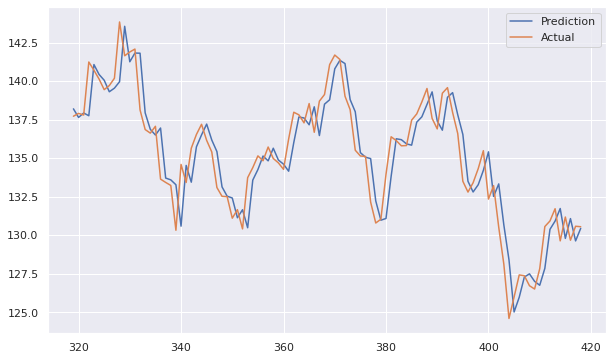

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_results_ba['Test Predictions'][-100:], label = 'Prediction')
plt.plot(test_results_ba['Actuals'][-100:], label= 'Actual')
plt.legend()
plt.show()


In [ ]:
### Calculate RMSE performance metrics for Training data
math.sqrt(mean_squared_error(yba_train,trainba_predict))

0.7004211444023513

In [ ]:
### Calculate RMSE for prediaction
math.sqrt(mean_squared_error(yba_test,testba_predict))

1.5731466828024858

The LSTM model prediction shows that the model performs well, the actual and prediction values in the dataframe are close. the two line graphs go up and down together. the RMSE for the test data is as small as the the training.

## Forcasting the next 30 days of Boeing Stock Prices

In [ ]:
# split the data into test and train, then get the last 50 days values

trainba_data = stock_prices_ba[:2610]
testba_data = stock_prices_ba[2610:]

In [ ]:
# This is teh function that we created before and use it for all our stocks data to get the out put of the forcast for the next 30 days

ba_forcast = forcast_30days(testba_data,model_ba,50,30)

1 day input [0.44162941 0.43915825 0.41853086 0.41101343 0.38825305 0.38502757
 0.38476747 0.35919781 0.34744044 0.34957343 0.37472689 0.39579648
 0.39366353 0.39072417 0.39088024 0.40510873 0.40862035 0.41535741
 0.42287484 0.40609719 0.40021849 0.42022161 0.42334303 0.40942671
 0.3975913  0.37082511 0.36479034 0.37001871 0.37795234 0.38799292
 0.36086257 0.36840599 0.34509939 0.32426386 0.29390802 0.30595153
 0.31833316 0.31789096 0.31227239 0.31042557 0.32179274 0.34546355
 0.34858497 0.35545209 0.33742585 0.35079595 0.33779002 0.34561961
 0.34535948 0.34397933]
1 day output [[0.3431322]]
2 day input [0.43915825 0.41853086 0.41101343 0.38825305 0.38502757 0.38476747
 0.35919781 0.34744044 0.34957343 0.37472689 0.39579648 0.39366353
 0.39072417 0.39088024 0.40510873 0.40862035 0.41535741 0.42287484
 0.40609719 0.40021849 0.42022161 0.42334303 0.40942671 0.3975913
 0.37082511 0.36479034 0.37001871 0.37795234 0.38799292 0.36086257
 0.36840599 0.34509939 0.32426386 0.29390802 0.30595153

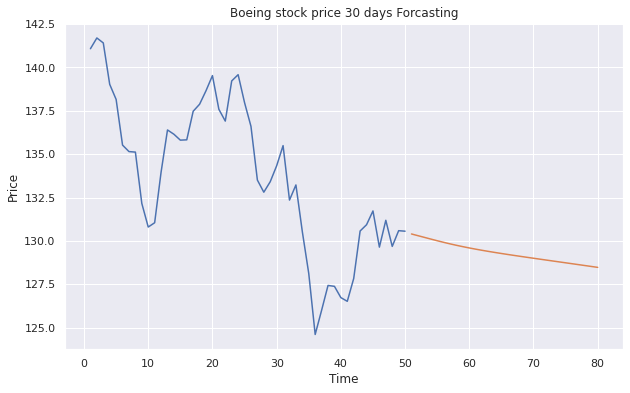

In [ ]:
# Plot the back 50 days and the future 30 days
newba_days=np.arange(1,51)
dayba_pred=np.arange(51,81)
plt.figure(figsize=(10,6))
plt.plot(newba_days,scaler.inverse_transform(stock_prices_ba[3029:]))
plt.plot(dayba_pred,scaler.inverse_transform(ba_forcast))

plt.title('Boeing stock price 30 days Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

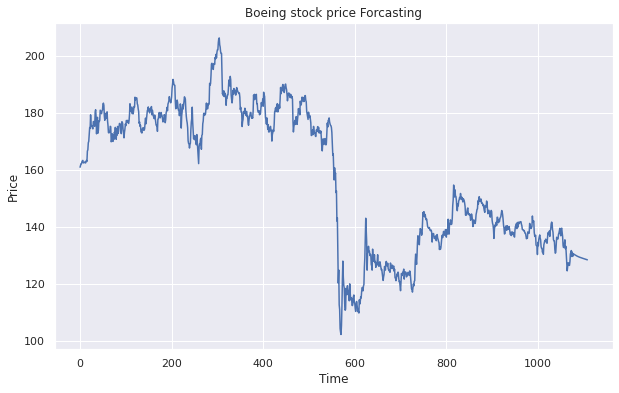

In [ ]:
# Plot all the data 


plt.figure(figsize=(10,6))
new_ba=stock_prices_ba.tolist()
new_ba.extend(ba_forcast)
plt.plot(scaler.inverse_transform(new_ba[2000:]))
plt.title('Boeing stock price Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

According to our mosel, the the forcast shows the price of Boeing for the next 30 days will be decreasing.

# IBM Stock Price Prediction

In [ ]:
# Get X and y values of IBM stock prices using the function we created before. 

step_size = 50
Xibm,yibm = get_x_y(stock_prices_ibm, step_size)
Xibm.shape, yibm.shape

# Split the data into train, validation and test

test_size = 0.15
Xibm_train, yibm_train = Xibm[:2000], yibm[:2000]
Xibm_val, yibm_val = Xibm[2000:2610], yibm[2000:2610]
Xibm_test, yibm_test = Xibm[2610:],   yibm[2610:]

Xibm_train.shape, yibm_train.shape, Xibm_val.shape, yibm_val.shape, Xibm_test.shape, yibm_test.shape

((2000, 50, 1), (2000, 1), (610, 50, 1), (610, 1), (419, 50, 1), (419, 1))

## Build The LSTM Model For Predicting IBM Stock Price

In [ ]:

n_features = 1  
n_steps = step_size

model_ibm=Sequential()
model_ibm.add(LSTM(100,return_sequences=True,input_shape=(n_steps, n_features)))
model_ibm.add(LSTM(50,return_sequences=True))
model_ibm.add(LSTM(50))
model_ibm.add(Dense(1))

model_ibm.compile(optimizer='adam', loss='mse')
# fit the model
model_ibm.fit(Xibm_train, yibm_train,validation_data=(Xibm_val,yibm_val), epochs=100, verbose=1)

Epoch 1/100
63/63 [==============================] - 15s 135ms/step - loss: 0.0229 - val_loss: 0.0043
Epoch 2/100
63/63 [==============================] - 7s 111ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/100
63/63 [==============================] - 7s 112ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 4/100
63/63 [==============================] - 7s 111ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 5/100
63/63 [==============================] - 7s 112ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/100
63/63 [==============================] - 7s 113ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/100
63/63 [==============================] - 7s 113ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/100
63/63 [==============================] - 7s 112ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 9/100
63/63 [==============================] - 7s 114ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/100
63/63 [==============================] - 7s 113ms/step - loss: 0.0011 - val_l

In [ ]:
model_ibm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 100)           40800     
                                                                 
 lstm_10 (LSTM)              (None, 50, 50)            30200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


### Prediction And Check Performance Metrics

In [ ]:
# Model prediction for unseen data

trainibm_predict=model_ibm.predict(Xibm_train)
testibm_predict=model_ibm.predict(Xibm_test)

In [ ]:
# Transform the scaled price back to the original price form

trainibm_predict=scaler.inverse_transform(trainibm_predict)
testibm_predict=scaler.inverse_transform(testibm_predict)
yibm_train = scaler.inverse_transform(yibm_train.reshape(-1,1))
yibm_test = scaler.inverse_transform(yibm_test.reshape(-1,1))

In [ ]:
trainibm_predict

array([[123.74197 ],
       [123.36608 ],
       [123.487946],
       ...,
       [148.93098 ],
       [147.69952 ],
       [146.9516  ]], dtype=float32)

In [ ]:
# Put the resultsinto the dataframe for visualization

testibm_predictions = testibm_predict.flatten()
yibm_test = yibm_test.flatten()

test_ibm_results = pd.DataFrame(data={'Test Predictions': testibm_predictions,'Actuals': yibm_test})
test_ibm_results.head()

,Test Predictions,Actuals
0,120.647606,119.808792
1,120.775444,117.495216
2,119.658195,117.533463
3,119.135757,118.843208
4,119.749916,120.305923


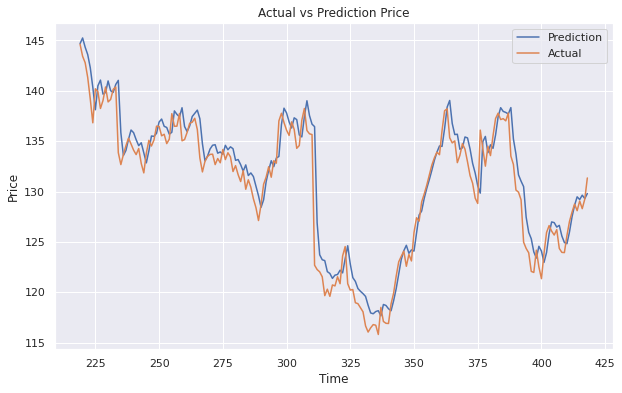

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_ibm_results['Test Predictions'][-200:], label = 'Prediction')
plt.plot(test_ibm_results['Actuals'][-200:], label= 'Actual')
plt.title('Actual vs Prediction Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
### Calculate RMSE performance metrics for Training data
math.sqrt(mean_squared_error(yibm_train,trainibm_predict))

2.1520127674400253

In [ ]:
### Calculate RMSE for prediaction
math.sqrt(mean_squared_error(yibm_test,testibm_predict))

2.2009319697662066

From the above results we can conclude that our LSTM model prediction is well. The values in the dataframe again not far btween the actual and the prediction prices. The two line graphs also went along. The values of RMSE also low for the training data as well as the test data. 

## Forcasting the next 30 days of IBM Stock Prices

In [ ]:
# Split the data into train and test and prepare the data to make suitable for the model to forcast for the next 30 days

train_ibm_data = stock_prices_ibm[:2610]
test_ibm_data = stock_prices_ibm[2610:]

In [ ]:
# The function for forcasting 

ibm_forcast = forcast_30days(test_ibm_data,model_ibm,50,30)

1 day input [0.376879   0.36590301 0.35414923 0.34758099 0.33487652 0.33029601
 0.3932133  0.37731102 0.36227318 0.37938527 0.37134782 0.38828702
 0.4031521  0.40773261 0.4022878  0.40306572 0.40116437 0.40781899
 0.37091567 0.36374239 0.3417904  0.33997556 0.33340718 0.29702239
 0.29166403 0.28794776 0.27195917 0.27109494 0.29019482 0.27576189
 0.26573657 0.28742923 0.30531917 0.31128251 0.30652911 0.30315855
 0.3078255  0.29166403 0.28829347 0.28812064 0.30281284 0.31491234
 0.32286341 0.32977735 0.32407341 0.33237013 0.32580189 0.33401222
 0.35216149 0.35373375]
1 day output [[0.36029828]]
2 day input [0.36590301 0.35414923 0.34758099 0.33487652 0.33029601 0.3932133
 0.37731102 0.36227318 0.37938527 0.37134782 0.38828702 0.4031521
 0.40773261 0.4022878  0.40306572 0.40116437 0.40781899 0.37091567
 0.36374239 0.3417904  0.33997556 0.33340718 0.29702239 0.29166403
 0.28794776 0.27195917 0.27109494 0.29019482 0.27576189 0.26573657
 0.28742923 0.30531917 0.31128251 0.30652911 0.30315855

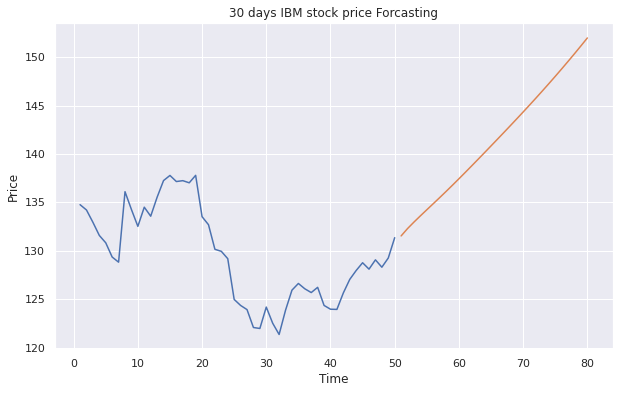

In [ ]:
# Plot value of the last 50 and 30 future days

day_ibm_new=np.arange(1,51)
day_ibm_pred=np.arange(51,81)
plt.figure(figsize=(10,6))

plt.plot(day_ibm_new,scaler.inverse_transform(stock_prices_ibm[3029:]))
plt.plot(day_ibm_pred,scaler.inverse_transform(ibm_forcast))


plt.title('30 days IBM stock price Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

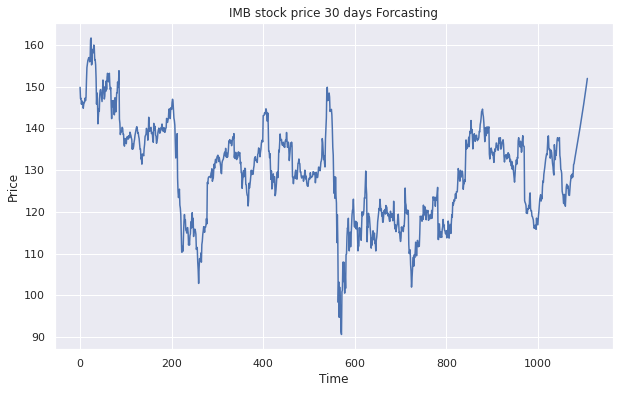

In [ ]:
# Plot all IBM stock price data along with the forcasting data

plt.figure(figsize=(10,6))
new_ibm=stock_prices_ibm.tolist()
new_ibm.extend(ibm_forcast)
plt.plot(scaler.inverse_transform(new_ibm[2000:]))
plt.title('IMB stock price 30 days Forcasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

According to our model, for the next 30 days the IBM price will be increasing.